<div dir="rtl">
<font face="B Nazanin" size="10">
سوال اول عملی تمرین سوم یادگیری عمیق
</font>
</div>

In [1]:
student_id = "402200253"
student_name = "Alireza Abbasian"

print("your student id:", student_id)
print("your name:", student_name)

your student id: 402200253
your name: Alireza Abbasian


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import Dataset

In [3]:
torch.manual_seed(1402)
np.random.seed(1402)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device = ",device)

device =  cuda


# preprocess data

<div dir="rtl">
<font face="B Nazanin" size="5">
در cell
زیر دیتاست
CIFAR10
را دانلود کرده ایم و داده های هواپیما و ماشین
را جدا کرده ایم.
و برای تست و train و
validation
دیتالودر درست کرده ایم.
مقادیر نرمالیزاسیون را هم از یک صفحه پرسش و پاسخ در گیت هاب استخراج کردم.
</font>
</div>

In [4]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# find index of 'airplane' and 'automobile' classes
class_names = ['airplane', 'automobile']
class_indices = [train_dataset.class_to_idx[class_name] for class_name in class_names]

# Filter data for 'airplane' and 'automobile' classes
train_filtered_indices = [i for i, label in enumerate(train_dataset.targets) if label in class_indices]
test_filtered_indices = [i for i, label in enumerate(test_dataset.targets) if label in class_indices]

# Create a subset of the dataset with only 'airplane' and 'automobile' classes
train_dataset = torch.utils.data.Subset(train_dataset, train_filtered_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_filtered_indices)

# Split the train_subset_dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for train, validation, and test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12959493.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


<div dir="rtl">
<font face="B Nazanin" size="5">
در cell
زیر ابعاد هر تصویر و سایز دیتای تست و ترین و ولیدیشن را حساب کرده ام.
</font>
</div>

In [5]:
# Print number of samples and dimensions in training dataset
print(f"Number of samples in the training dataset: {len(train_dataset)}")
print(f"Dimensions of each training sample: {train_dataset[0][0].shape}")

# Print number of samples and dimensions in validation dataset
print(f"\nNumber of samples in the validation dataset: {len(val_dataset)}")
print(f"Dimensions of each validation sample: {val_dataset[0][0].shape}")

# Print number of samples and dimensions in test dataset
print(f"\nNumber of samples in the test dataset: {len(test_dataset)}")
print(f"Dimensions of each test sample: {test_dataset[0][0].shape}")

Number of samples in the training dataset: 8000
Dimensions of each training sample: torch.Size([3, 32, 32])

Number of samples in the validation dataset: 2000
Dimensions of each validation sample: torch.Size([3, 32, 32])

Number of samples in the test dataset: 2000
Dimensions of each test sample: torch.Size([3, 32, 32])


<div dir="rtl">
<font face="B Nazanin" size="5">
در cell
زیر
سه نمونه دیتای train
نمایش داده شده است.
</font>
</div>

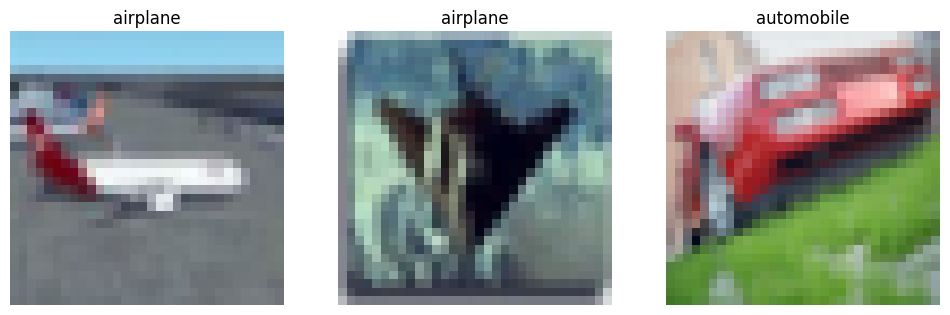

In [6]:
# Display two images for each class
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    img, label = train_dataset[i]
    img = np.transpose(img.numpy(), (1, 2, 0))  # Transpose to (height, width, channels) for display
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize to [0, 1]
    axs[i].imshow(img)
    axs[i].set_title(class_names[label])
    axs[i].axis('off')

plt.show()

<div dir="rtl">
<font face="B Nazanin" size="5">

</font>
</div>

# part 1: cross entropy loss

<div dir="rtl">
<font face="B Nazanin" size="5">
در cell
زیر کلاس my_classifir
را توصیف کرده ام.
این کلاس یک
feature_extractor
را با یک شبکه FC
یک لایه ای به هم متصل می کند.




</font>
</div>

In [7]:
class My_classifier(nn.Module):

    def __init__ (self, feature_extractor, num_features, num_output):
        super(My_classifier, self).__init__()
        self.feature_extractor = feature_extractor
        self.fc = nn.Linear(num_features, num_output)

    def forward(self, x):
        features = self.feature_extractor(x)
        outputs = self.fc(features)
        return features, outputs

<div dir="rtl">
<font face="B Nazanin" size="5">
برای feature_extractor
من
resnet50
را انتخاب کرده ام.
آن را با وزن های پیش آموزش داده شده دانلود کرده ام.
سپس به کلاس خودم اضافه کرده ام.

</font>
</div>

In [8]:
# Load pre-trained ResNet50 model
feature_extractor = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
num_out_features_of_resnet = feature_extractor.fc.in_features
feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

model = My_classifier(feature_extractor, num_out_features_of_resnet, len(class_names))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 74.9MB/s]


<div dir="rtl">
<font face="B Nazanin" size="5">
در cell
زیر من تابع
evaluate_model
را تعریف کرده ام که مدل و دیتالودر را می گیرد و دقت و صحت مدل را محاسبه می کند.





</font>
</div>

In [9]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for x, labels in tqdm(dataloader):
            x = x.to(device)
            labels = labels.to(device)
            _, outputs = model(x)
            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')

    return accuracy, precision

<div dir="rtl">
<font face="B Nazanin" size="5">

در سلول زیر فرایند یادگیری انجام شده است.
توجه کنید که در هر ایپاک یک بار روی کل دیتالود ترین و یک بار هم روی ولیدیشن
تابع
evaluate_model
را صدا میزنیم تا دقت و صحت مدل را ببینیم.



</font>
</div>

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 4

train_losses = []
train_accuracies = []
train_precisions = []
val_accuracies = []
val_precisions = []

# Training

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')

    model.train()
    running_loss = 0.0

    print("training loop:")
    for x, labels in tqdm(train_loader):
        x = x.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        _, outputs = model(x)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)

    print("evaluation loop:")
    # Evaluate on the training set
    train_accuracy, train_precision = evaluate_model(model, train_loader, criterion)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)

    print("validation loop:")
    # Evaluate on the validation set
    val_accuracy, val_precision = evaluate_model(model, val_loader, criterion)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)


    print(f'Loss: {average_loss:.4f}')
    print(f'Train Accuracy: {train_accuracy*100:.2f} %, Train Precision: {train_precision*100:.2f} %')
    print(f'Validation Accuracy: {val_accuracy*100:.2f} %, Validation Precision: {val_precision*100:.2f} %')

Epoch 1/4
training loop:


100%|██████████| 125/125 [00:08<00:00, 14.48it/s]


evaluation loop:


100%|██████████| 125/125 [00:04<00:00, 29.74it/s]


validation loop:


100%|██████████| 32/32 [00:00<00:00, 32.20it/s]


Loss: 0.2315
Train Accuracy: 97.75 %, Train Precision: 97.76 %
Validation Accuracy: 95.75 %, Validation Precision: 95.76 %
Epoch 2/4
training loop:


100%|██████████| 125/125 [00:06<00:00, 18.22it/s]


evaluation loop:


100%|██████████| 125/125 [00:03<00:00, 31.37it/s]


validation loop:


100%|██████████| 32/32 [00:00<00:00, 36.21it/s]


Loss: 0.0988
Train Accuracy: 99.42 %, Train Precision: 99.43 %
Validation Accuracy: 97.80 %, Validation Precision: 97.80 %
Epoch 3/4
training loop:


100%|██████████| 125/125 [00:06<00:00, 18.24it/s]


evaluation loop:


100%|██████████| 125/125 [00:03<00:00, 34.78it/s]


validation loop:


100%|██████████| 32/32 [00:01<00:00, 28.27it/s]


Loss: 0.0419
Train Accuracy: 99.58 %, Train Precision: 99.58 %
Validation Accuracy: 97.35 %, Validation Precision: 97.35 %
Epoch 4/4
training loop:


100%|██████████| 125/125 [00:06<00:00, 18.03it/s]


evaluation loop:


100%|██████████| 125/125 [00:03<00:00, 39.62it/s]


validation loop:


100%|██████████| 32/32 [00:00<00:00, 32.01it/s]

Loss: 0.0323
Train Accuracy: 99.60 %, Train Precision: 99.60 %
Validation Accuracy: 97.85 %, Validation Precision: 97.85 %


<div dir="rtl">
<font face="B Nazanin" size="5">

در زیر نمودار های دقت و صحت مدل را
هم روی دیتای ترین و هم  ولیدیشن در هر ایپاک
 رسم کرده ام.

هم چنین مقدار trainig loss
هم در هر ایپاک رسم شده

میبینید که میتوانستیم باز ایپاک بیشتری ران کنیم ولی چون دقت
بالا بود و میخواستم سریغ هر سلول اجرا شود ایپاک ها را کم کردم.
</font>
</div>

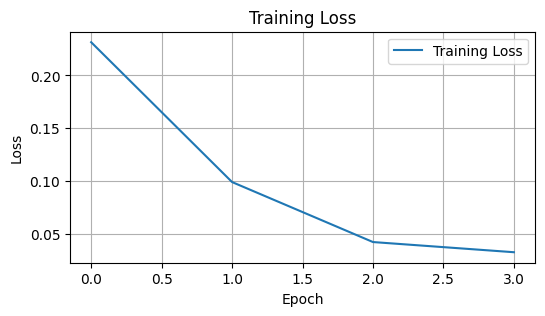

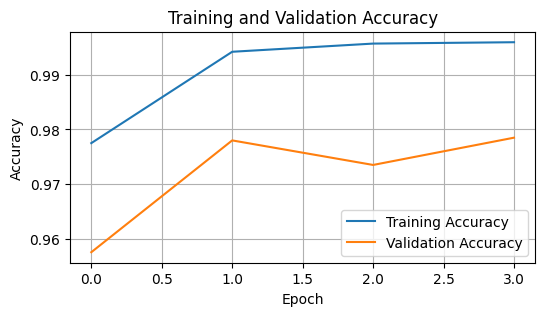

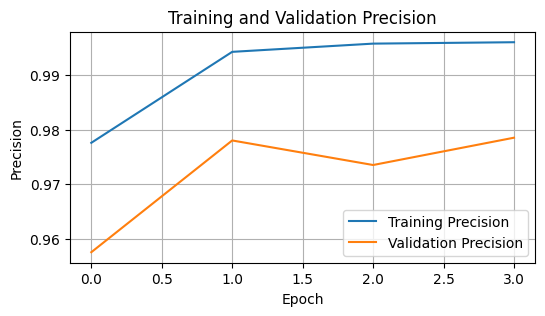

In [11]:
# Plot Loss
plt.figure(figsize=(6, 3))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(6, 3))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision
plt.figure(figsize=(6, 3))
plt.plot(train_precisions, label='Training Precision')
plt.plot(val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.grid(True)
plt.show()


<div dir="rtl">
<font face="B Nazanin" size="5">
نتایج تست را در زیر میبینید.
</font>
</div>

In [12]:
test_accuracy, test_precision = evaluate_model(model, test_loader, criterion)

print('\ntest accuracy = %.2f %%' %(test_accuracy*100))
print('test precision = %.2f %%' %(test_precision*100))

100%|██████████| 32/32 [00:01<00:00, 25.10it/s]


test accuracy = 97.65 %
test precision = 97.65 %


# part 2: triplet loss

<div dir="rtl">
<font face="B Nazanin" size="5">

در سلول زیر
کلاس
CustomDataset
را نوشته ام.
این کلاس دیتاست اصلی را میگیرد
و برای هر تصویر
در تابع
__getitem__
یک تصویر مثبت و یک تصویر منفی را انتخاب میکند.
به این صورت که تصویری به جز ایندکس تصویر اصلی ولی از همان کلاس را به عنوان تصویر مثبت انتخاب میکند.
و مشابه همان از کلاسی دیگر را به عنوان تصویر منفی انتخاب میکند.
هر سه تصویر به همراه لیبل هایشان را بر میگرداند.

</font>
</div>

In [13]:
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.num_samples = len(dataset)

    def __getitem__(self, index):
        anchor_data, anchor_label = self.dataset[index]

        positive_index = index
        while positive_index == index or self.dataset[positive_index][1] != anchor_label:
            positive_index = torch.randint(0, self.num_samples, (1,)).item()
        positive_data, positive_label = self.dataset[positive_index]

        negative_index = index
        while negative_index == index or self.dataset[negative_index][1] == anchor_label:
            negative_index = torch.randint(0, self.num_samples, (1,)).item()
        negative_data, negative_label = self.dataset[negative_index]

        return anchor_data, anchor_label, positive_data, positive_label, negative_data, negative_label

    def __len__(self):
        return self.num_samples


In [14]:
train_loader_triplet = DataLoader(CustomDataset(train_dataset), batch_size=64, shuffle=True)

In [15]:
# Load pre-trained ResNet50 model
feature_extractor = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
num_out_features_of_resnet = feature_extractor.fc.in_features
feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

In [16]:
criterion =  nn.TripletMarginLoss(margin=7, p=2)
optimizer = optim.Adam(feature_extractor.parameters(), lr=1e-3)

num_epochs = 4

<div dir="rtl">
<font face="B Nazanin" size="5">

در سلول زیر برای feature_extractor
که همان resnet50
است یادگیری انجام میشود.
برای
تابع هزینه
از معیار
TripletMarginLoss
استفاده میکند.
در هر ایتریشن با کمک دیتاست جدید سه تصویر را میگیرد و هزینه را محاسبه میکند.

در ادامه نمودار loss
در هر ابپاک هم رسم شده است

</font>
</div>

In [17]:

train_losses = []
train_accuracies = []
train_precisions = []
val_accuracies = []
val_precisions = []

# Training

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')

    model.train()
    running_loss = 0.0

    for anchor_data, anchor_label, positive_data, positive_label, negative_data, negative_label in tqdm(train_loader_triplet):
        anchor_data = anchor_data.to(device)
        anchor_label = anchor_label.to(device)
        positive_data = positive_data.to(device)
        negative_data = negative_data.to(device)

        optimizer.zero_grad()
        features_anchor = feature_extractor(anchor_data)
        features_positive = feature_extractor(positive_data)
        features_negative = feature_extractor(negative_data)
        loss = criterion(features_anchor, features_positive, features_negative)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)


Epoch 1/4


100%|██████████| 125/125 [00:30<00:00,  4.16it/s]


Epoch 2/4


100%|██████████| 125/125 [00:29<00:00,  4.23it/s]


Epoch 3/4


100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


Epoch 4/4


100%|██████████| 125/125 [00:28<00:00,  4.35it/s]


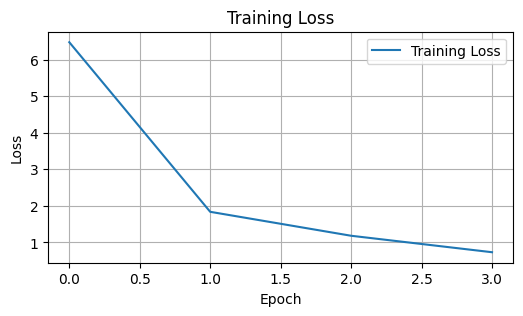

In [18]:
plt.figure(figsize=(6, 3))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

<div dir="rtl">
<font face="B Nazanin" size="5">

حال در سلول زیر
کل
feature_extractor
را freeze
میکنیم و یک شبکه
FC
یک لایه ای به آن اضافه میکنیم.
و آن را آموزش میدهیم

نمودار ها رسم شده و نتایج مشخص است

</font>
</div>

In [19]:
for params in feature_extractor.parameters():
    params.requires_grad = False

model = My_classifier(feature_extractor, num_out_features_of_resnet, len(class_names))
model = model.to(device)

In [20]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 4

train_losses = []
train_accuracies = []
train_precisions = []
val_accuracies = []
val_precisions = []

# Training

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')

    model.train()
    running_loss = 0.0

    print("training loop:")
    for x, labels in tqdm(train_loader):
        x = x.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        _, outputs = model(x)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)

    print("evaluation loop:")
    # Evaluate on the training set
    train_accuracy, train_precision = evaluate_model(model, train_loader, criterion)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)

    print("validation loop:")
    # Evaluate on the validation set
    val_accuracy, val_precision = evaluate_model(model, val_loader, criterion)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)


    print(f'Loss: {average_loss:.4f}')
    print(f'Train Accuracy: {train_accuracy*100:.2f} %, Train Precision: {train_precision*100:.2f} %')
    print(f'Validation Accuracy: {val_accuracy*100:.2f} %, Validation Precision: {val_precision*100:.2f} %')

Epoch 1/4
training loop:


100%|██████████| 125/125 [00:03<00:00, 35.83it/s]


evaluation loop:


100%|██████████| 125/125 [00:03<00:00, 35.96it/s]


validation loop:


100%|██████████| 32/32 [00:00<00:00, 33.07it/s]


Loss: 0.3102
Train Accuracy: 98.64 %, Train Precision: 98.64 %
Validation Accuracy: 97.35 %, Validation Precision: 97.35 %
Epoch 2/4
training loop:


100%|██████████| 125/125 [00:04<00:00, 29.72it/s]


evaluation loop:


100%|██████████| 125/125 [00:03<00:00, 34.30it/s]


validation loop:


100%|██████████| 32/32 [00:00<00:00, 37.06it/s]


Loss: 0.1271
Train Accuracy: 98.61 %, Train Precision: 98.61 %
Validation Accuracy: 97.35 %, Validation Precision: 97.35 %
Epoch 3/4
training loop:


100%|██████████| 125/125 [00:03<00:00, 35.88it/s]


evaluation loop:


100%|██████████| 125/125 [00:04<00:00, 28.32it/s]


validation loop:


100%|██████████| 32/32 [00:00<00:00, 35.24it/s]


Loss: 0.0988
Train Accuracy: 98.62 %, Train Precision: 98.63 %
Validation Accuracy: 97.40 %, Validation Precision: 97.40 %
Epoch 4/4
training loop:


100%|██████████| 125/125 [00:03<00:00, 36.08it/s]


evaluation loop:


100%|██████████| 125/125 [00:03<00:00, 36.07it/s]


validation loop:


100%|██████████| 32/32 [00:00<00:00, 37.40it/s]

Loss: 0.0781
Train Accuracy: 98.59 %, Train Precision: 98.59 %
Validation Accuracy: 97.25 %, Validation Precision: 97.25 %


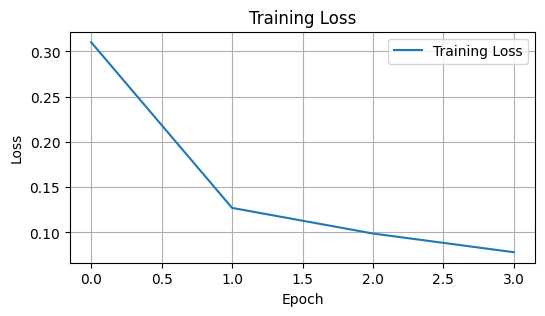

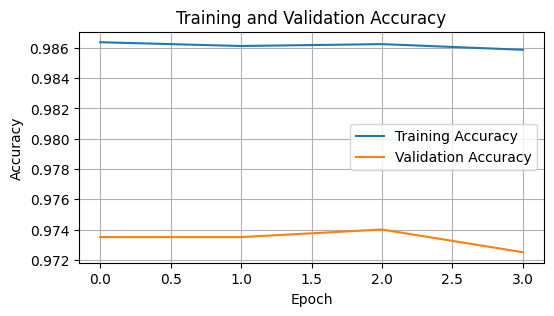

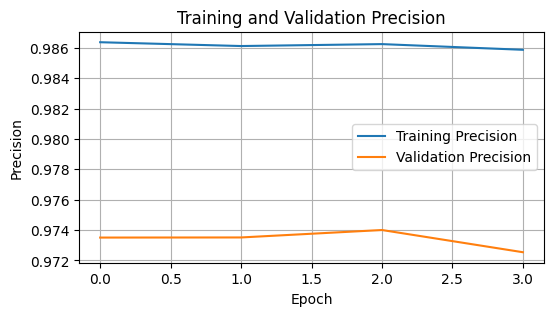

In [21]:
plt.figure(figsize=(6, 3))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(6, 3))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision
plt.figure(figsize=(6, 3))
plt.plot(train_precisions, label='Training Precision')
plt.plot(val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
test_accuracy, test_precision = evaluate_model(model, test_loader, criterion)

print('\ntest accuracy = %.2f %%' %(test_accuracy*100))
print('test precision = %.2f %%' %(test_precision*100))

100%|██████████| 32/32 [00:01<00:00, 25.39it/s]


test accuracy = 97.90 %
test precision = 97.90 %


# part 3: adding 2 loss

<div dir="rtl">
<font face="B Nazanin" size="5">

از ابتدا کلاس
My_classifier
را به گونه ای نوشتم که در forward
هم خروجی feature_extractor
و هم خروجی FC
را برگرداند پس در فرایتند ترینینگ
سه عکس
anchor
و
positive
و
negative
را به مدل میدهیم و تابع هزینه
triplet loss
را با سه تا تابع هزینه
cross entropy
  جمع میکنیم.

  در آخر مثل قسمت های قبل نمودار ها نشان داده شده و نتایج مشخص است.



</font>
</div>

In [23]:
feature_extractor = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
num_out_features_of_resnet = feature_extractor.fc.in_features
feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

model = My_classifier(feature_extractor, num_out_features_of_resnet, len(class_names))
model = model.to(device)

In [24]:
criterion_CrossEntropy = nn.CrossEntropyLoss()
criterion_triplet =  nn.TripletMarginLoss(margin=7, p=2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 4

train_losses = []
train_accuracies = []
train_precisions = []
val_accuracies = []
val_precisions = []

# Training

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')

    model.train()
    running_loss = 0.0

    print("training loop:")
    for anchor_data, anchor_label, positive_data, positive_label, negative_data, negative_label in tqdm(train_loader_triplet):
        anchor_data = anchor_data.to(device)
        anchor_label = anchor_label.to(device)
        positive_data = positive_data.to(device)
        positive_label = positive_label.to(device)
        negative_data = negative_data.to(device)
        negative_label = negative_label.to(device)

        optimizer.zero_grad()
        features_anchor, output_anchor = model(anchor_data)
        features_positive, output_positive = model(positive_data)
        features_negative, output_negative = model(negative_data)
        loss = criterion_triplet(features_anchor, features_positive, features_negative) + \
                       criterion_CrossEntropy(output_anchor, anchor_label)     +\
                       criterion_CrossEntropy(output_positive, positive_label)   +\
                       criterion_CrossEntropy(output_negative, negative_label)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)

    print("evaluation loop:")
    # Evaluate on the training set
    train_accuracy, train_precision = evaluate_model(model, train_loader, criterion)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)

    print("validation loop:")
    # Evaluate on the validation set
    val_accuracy, val_precision = evaluate_model(model, val_loader, criterion)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)


    print(f'Loss: {average_loss:.4f}')
    print(f'Train Accuracy: {train_accuracy*100:.2f} %, Train Precision: {train_precision*100:.2f} %')
    print(f'Validation Accuracy: {val_accuracy*100:.2f} %, Validation Precision: {val_precision*100:.2f} %')

Epoch 1/4
training loop:


100%|██████████| 125/125 [00:28<00:00,  4.35it/s]


evaluation loop:


100%|██████████| 125/125 [00:03<00:00, 38.18it/s]


validation loop:


100%|██████████| 32/32 [00:00<00:00, 37.59it/s]


Loss: 6.5766
Train Accuracy: 96.17 %, Train Precision: 96.19 %
Validation Accuracy: 94.55 %, Validation Precision: 94.55 %
Epoch 2/4
training loop:


100%|██████████| 125/125 [00:28<00:00,  4.39it/s]


evaluation loop:


100%|██████████| 125/125 [00:04<00:00, 29.88it/s]


validation loop:


100%|██████████| 32/32 [00:00<00:00, 35.08it/s]


Loss: 1.1557
Train Accuracy: 98.94 %, Train Precision: 98.94 %
Validation Accuracy: 97.45 %, Validation Precision: 97.47 %
Epoch 3/4
training loop:


100%|██████████| 125/125 [00:37<00:00,  3.33it/s]


evaluation loop:


100%|██████████| 125/125 [00:03<00:00, 35.19it/s]


validation loop:


100%|██████████| 32/32 [00:00<00:00, 36.38it/s]


Loss: 0.3870
Train Accuracy: 99.54 %, Train Precision: 99.54 %
Validation Accuracy: 97.50 %, Validation Precision: 97.57 %
Epoch 4/4
training loop:


100%|██████████| 125/125 [00:28<00:00,  4.38it/s]


evaluation loop:


100%|██████████| 125/125 [00:03<00:00, 38.31it/s]


validation loop:


100%|██████████| 32/32 [00:01<00:00, 28.54it/s]

Loss: 0.2833
Train Accuracy: 99.59 %, Train Precision: 99.59 %
Validation Accuracy: 97.70 %, Validation Precision: 97.70 %


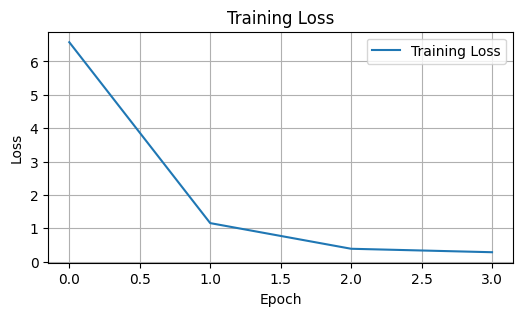

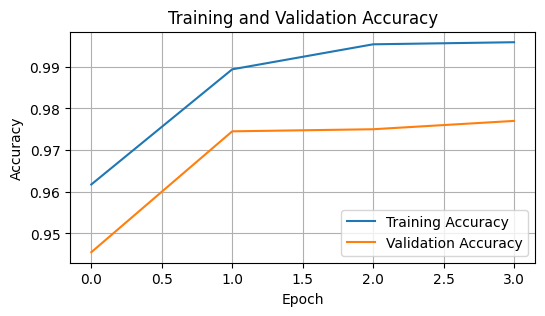

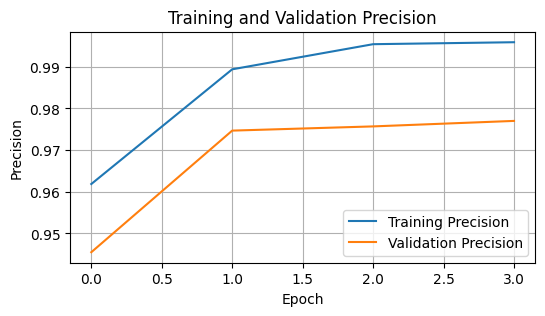

In [25]:
plt.figure(figsize=(6, 3))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(6, 3))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision
plt.figure(figsize=(6, 3))
plt.plot(train_precisions, label='Training Precision')
plt.plot(val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
test_accuracy, test_precision = evaluate_model(model, test_loader, criterion)

print('\ntest accuracy = %.2f %%' %(test_accuracy*100))
print('test precision = %.2f %%' %(test_precision*100))

100%|██████████| 32/32 [00:01<00:00, 26.22it/s]


test accuracy = 97.60 %
test precision = 97.60 %
